# Multi-Class SVM

This exercise guides you through the process of classifying images using Support Vector Machines(SVM). As part of this you will:

- Implement a fully vectorized loss function and for the SVM
- Calculate the analytical gradient using vectorized code
- Perform Stochastic Gradient Descent (SGD) to minimize the loss function
- Validate to tune the hyper-parameters
- Visualize the learned weights

In [1]:
# start-up code to import data-sets
from f16RBE595.get_cifar10 import load_CIFAR10
# loading some necessary packages
import numpy as np
import random
import matplotlib.pyplot as plt

# This is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some code so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading and Pre-processing CIFAR-10

Before proceeding, go to `WPI-F16-RBE595-HW1/f16RBE595/data/` and run the script `.get_datasets.sh` to download the CIFAR-10 data. 

In [2]:
# Assuming you have downloaded the CIFAR-10 database in your WPI-F16-RBE595-HW1/f16RBE595/data folder, 
# we proceed to load the data into python
cifar10_dir = 'f16RBE595/data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


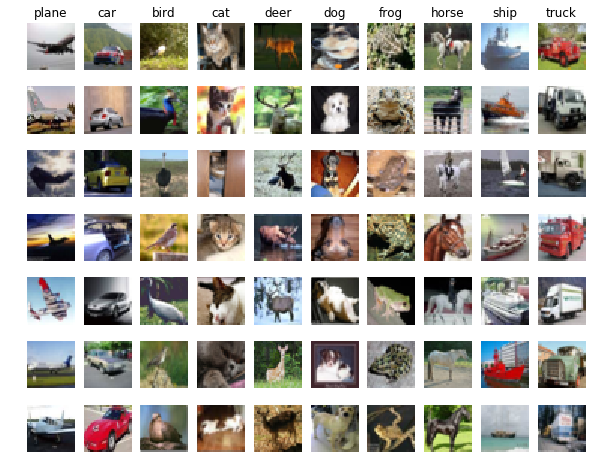

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 49000
num_validation = 1000
num_test = 1000

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_training points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


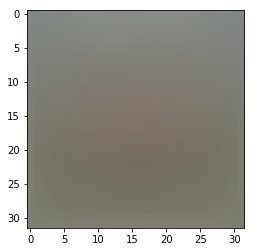

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
# print X_train[0][-1]
print X_train.shape, X_val.shape, X_test.shape

(3073L, 49000L) (3073L, 1000L) (3073L, 1000L)


## SVM Classifier
Code for this section will all be written inside `f16RBE595/classifiers/linear_svm.py`.

In [47]:
from f16RBE595.classifiers.linear_svm import svm_loss_vectorized
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(10,3073) * 0.0001 
print W.shape
# Implement a vectorized code to implement the loss and the gradient of the SVM. 
# Remember that your code should not have any loops. 
# Hint:
# Look up the broadcasting property of np arrays
# In case you have memory errors, you might want to use float16 or pickle your data
# check np.ndarray.dump()/load() if you consider pickling your data
                    
tic = time.time()
loss, grad = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)
# It should be quite fast and finish within a second if your code is optimized! 

# check 
print 'loss is: ', loss
# if your implementation is correct, loss should be around 9.0. 

# gradient check - The relative error between the numerical gradient and 
# your analytical gradient must be small 
from f16RBE595.gradient_check import grad_check_sparse
f = lambda w: svm_loss_vectorized(w, X_train, y_train, 0.0)[0]
grad_check_sparse(f, W, grad, 10)

(10L, 3073L)
Vectorized loss and gradient: computed in 0.354000s
loss is:  44411.0138722
numerical: -43826.719448 analytic: -8.947343, relative error: 9.995918e-01
numerical: 24797.497811 analytic: 5.060516, relative error: 9.995919e-01
numerical: 23624.180693 analytic: 4.821697, relative error: 9.995919e-01
numerical: -127.525206 analytic: -0.026188, relative error: 9.995894e-01
numerical: 52851.548406 analytic: 10.786352, relative error: 9.995919e-01
numerical: -16140.895323 analytic: -3.295677, relative error: 9.995917e-01
numerical: 71825.477748 analytic: 14.659873, relative error: 9.995919e-01
numerical: -47872.173686 analytic: -9.768336, relative error: 9.995920e-01
numerical: -34682.434380 analytic: -7.082146, relative error: 9.995917e-01
numerical: 74996.156196 analytic: 15.304818, relative error: 9.995919e-01


## Stochastic Gradient Descent (SGD)
Code for this section will be written in `f16RBE595/classifiers/linear_classifier.py`

In [ ]:
# Now that we have efficient implementations for computing loss and gradients, let us use SGD to minimize 
# loss funtion

In [48]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from f16RBE595.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

float64
iteration 0 / 1500: loss 1236.324765
iteration 100 / 1500: loss 422.434607
iteration 200 / 1500: loss 214.970809
iteration 300 / 1500: loss 143.581626
iteration 400 / 1500: loss 130.138064
iteration 500 / 1500: loss 100.047053
iteration 600 / 1500: loss 108.300258
iteration 700 / 1500: loss 104.206355
iteration 800 / 1500: loss 98.046035
iteration 900 / 1500: loss 93.888807
iteration 1000 / 1500: loss 91.388004
iteration 1100 / 1500: loss 107.664131
iteration 1200 / 1500: loss 102.527762
iteration 1300 / 1500: loss 92.904654
iteration 1400 / 1500: loss 104.161417
That took 6.190000s


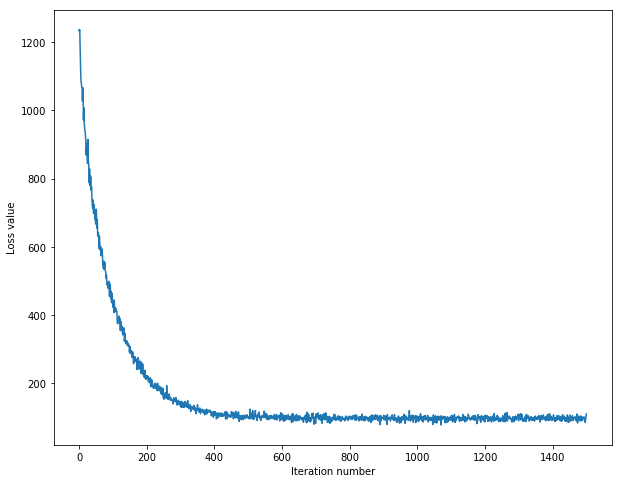

In [35]:
# A useful debugging strategy is to plot the training loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [36]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.373857
validation accuracy: 0.385000


(10L, 3072L)


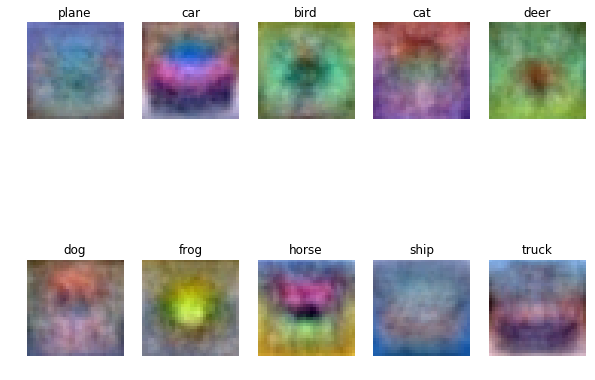

In [39]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:,:-1] # strip out the bias
print w.shape
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])